In [12]:
# ! pip install tensorflow
# ! pip install wandb
# ! pip install cupy-cuda102

     |████████████████████████████████| 63.1 MB 1.1 MB/s eta 0:00:011B/s eta 0:02:03 eta 0:02:001:57    | 24.7 MB 420 kB/s eta 0:01:32███████                   | 25.5 MB 420 kB/s eta 0:01:30��███████▎              | 34.1 MB 11.3 MB/s eta 0:00:03eta 0:00:03��██████          | 43.4 MB 4.5 MB/s eta 0:00:05██████▌         | 44.3 MB 4.5 MB/s eta 0:00:05█████████████████████         | 45.5 MB 4.5 MB/s eta 0:00:04[K     |████████████████████████████    | 55.2 MB 14.3 MB/s eta 0:00:01��██████████████████████▏   | 55.6 MB 14.3 MB/s eta 0:00:01████████▋   | 56.4 MB 14.3 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 10.0 MB/s eta 0:00:01


## Import Statements

In [25]:
from keras.datasets import fashion_mnist
import wandb
wandb.init(project='DLCourse')
import numpy as np
cp.random.seed(999)
import cupy as cp
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## [Quest#1] Plot Sample Images

In [27]:
# define classes and load data in memory
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', \
    'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

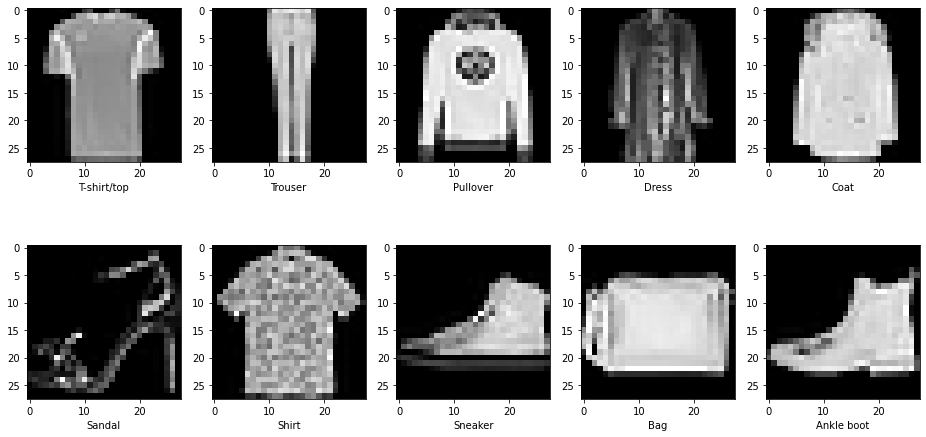

In [28]:
# Plot random sample from each class
log_images=[]
for i,cl in enumerate(classes):
  plt.subplot(2, 5, i+1)
  indexes = cp.where(y_train == i)
  idx = np.random.choice(indexes[0])
  log_images.append(wandb.Image(x_train[idx], caption=cl))
  plt.imshow(x_train[idx], cmap=plt.get_cmap('gray'))
  plt.xlabel(cl)
plt.show()

wandb.log({"Classwise Samples": log_images})

<br>

## [Quest#2] Implement Feedforward Neural Network

### Activation Functions

In [95]:
from abc import ABC
import cupy as cp

def activation_types():
    return [x.__name__ for x in Activation.__subclasses__()]


class Activation:
    def __call__(self, x):
        raise NotImplementedError

    def backward(self, x):
        raise NotImplementedError

class Sigmoid(Activation, ABC):
    # https://stackoverflow.com/a/23194336/12732481
    def __call__(self, x):
        """Numerically stable sigmoid function."""
        xp = cp.get_array_module(x)
        x = xp.clip(x, -500, 500)
        return 1 / (1 + xp.exp(-x))

    def backward(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

class Linear(Activation, ABC):
    def __call__(self, x):
        xp = cp.get_array_module(x)
        return xp.asarray(x)

    def backward(self, x):
        return cp.ones_like(x)

class ReLU(Activation, ABC):
    def __call__(self, x):
        xp = cp.get_array_module(x)
        return xp.maximum(0, x)

    def backward(self, x):
        return cp.where(x > 0, cp.ones_like(x), cp.zeros_like(x))

class Tanh(Activation, ABC):
    def __call__(self, x):
        xp = cp.get_array_module(x)
        return xp.tanh(x)

    def backward(self, x):
        return 1 - self.__call__(x) ** 2


### Initialization Functions

In [96]:
import math

def supported_initializers():
    return [x.__name__ for x in Initializer.__subclasses__()]


class Initializer:
    def initialize(self, x):
        raise NotImplementedError


class Constant(Initializer, ABC):
    def __init__(self, constant=0):
        self._const = constant

    def initialize(self, shape):
        return self._const * cp.ones(shape)

class Uniform(Initializer, ABC):
    def initialize(self, shape):
        return cp.random.uniform(0, 1, shape)

class Xavier(Initializer, ABC):
    def initialize(self, shape):
        fan_in, fan_out = shape
        std = math.sqrt(2 / (fan_in + fan_out))
        a = std * math.sqrt(3)
        return cp.random.uniform(-a, a, shape)

class HeNormal(Initializer, ABC):
    def __init__(self, non_linearity, mode="fan_in"):
        if not isinstance(non_linearity, Activation):
            raise Exception()
        self.non_linearity = non_linearity
        self.mode = mode

    def initialize(self, shape):
        fan_in, fan_out = shape
        fan = fan_in if self.mode == "fan_in" else fan_out
        if isinstance(self.non_linearity, ReLU):
            gain = math.sqrt(2)
        else:
            raise NotImplementedError
        std = gain / math.sqrt(fan)
        return cp.random.normal(0, std, shape)

In [102]:
def supported_layers():
    return [x.__name__ for x in ParamLayer.__subclasses__()]


class Layer:
    def __call__(self, **kwargs):
        raise NotImplementedError

    def backward(self, **x):
        raise NotImplementedError


class ParamLayer(Layer, ABC):
    def __init__(self,
                 weight_shape,
                 weight_initializer,
                 bias_initializer,
                 regularizer_type: str = None,
                 lam: float = 0.
                 ):
        self.vars = {"W": weight_initializer.initialize(weight_shape),
                     "b": bias_initializer.initialize((1, weight_shape[1])),
                     "dW": cp.zeros(weight_shape),
                     "db": cp.zeros((1, weight_shape[1]))}

        self.z = None
        self.input = None

        self.regularizer_type = regularizer_type  # noqa
        self.lam = lam

    def summary(self):
        name = self.__class__.__name__
        n_param = self.vars["W"].shape[0] * self.vars["W"].shape[1] + self.vars["b"].shape[1]
        output_shape = (None, self.vars["b"].shape[1])
        return name, output_shape, n_param

    @property
    def input_shape(self):
        return self.vars["W"].shape[0]


class Dense(ParamLayer, ABC):
    def __init__(self, in_features: int,
                 out_features: int,
                 activation: Activation = Linear(),
                 weight_initializer: Initializer = Uniform(),
                 bias_initializer: Initializer = Constant(),
                 regularizer_type: str = None,
                 lam: float = 0.
                 ):
        super().__init__(weight_shape=(in_features, out_features),
                         weight_initializer=weight_initializer,
                         bias_initializer=bias_initializer,
                         regularizer_type=regularizer_type,
                         lam=lam
                         )
        self.in_features = in_features
        self.out_features = out_features
        self.act = activation
        self.weight_initializer = weight_initializer
        self.bias_initializer = bias_initializer
        self.regularizer_type = regularizer_type
        self.lam = lam

    def __call__(self, x):
        x = cp.asarray(x)
        assert len(x.shape) > 1, "Feed the input to the network in batch mode: (batch_size, n_dims)"
        self.input = x
        z = x.dot(self.vars["W"]) + self.vars["b"]
        self.z = z
        a = self.act(z)
        return a

    def backward(self, **delta):
        #  https://cs182sp21.github.io/static/slides/lec-5.pdf
        delta = delta["delta"]
        dz = delta * self.act.backward(self.z)
        self.vars["dW"] = self.input.T.dot(dz) / dz.shape[0]
        self.vars["db"] = cp.sum(dz, axis=0, keepdims=True) / dz.shape[0]

        if self.regularizer_type == "l2":
            self.vars["dW"] += self.lam * self.vars["W"]
            # Biases are not regularized: https://cs231n.github.io/neural-networks-2/#reg
            # self.vars["db"] += self.lam * self.vars["b"]
        elif self.regularizer_type == "l1":
            self.vars["dW"] += self.lam
            # self.vars["db"] += self.lam

        delta = dz.dot(self.vars["W"].T)
        return dict(delta=delta)

In [159]:
def supported_losses():
    return [x.__name__ for x in LossFunc.__subclasses__()]


class Loss:
    def __init__(self, value, delta):
        self.value = value
        self.delta = delta


class LossFunc:
    def __init__(self, pred=None, target=None):
        self.pred = pred
        self.target = target
        self.eps = 1e-6

    def apply(self, p, t):
        raise NotImplementedError

    @property
    def delta(self):
        raise NotImplementedError

    def __call__(self, p, t):
        return self.apply(p, t)

class MSE(LossFunc, ABC):
    def __init__(self):
        super(MSE, self).__init__()

    def apply(self, p, t):
        super(MSE, self).__init__(p, t)
        return Loss(cp.mean((p - t) ** 2, axis=0) / 2, self.delta)

    @property
    def delta(self):
        return self.pred - self.target


class CrossEntropy(LossFunc, ABC):
    #  https://cs231n.github.io/neural-networks-case-study/#grad
    def __init__(self):
        super(CrossEntropy, self).__init__()

    def apply(self, p, t):
        super(CrossEntropy, self).__init__(p, t)
        probs = self.softmax(p)
        loss = -cp.log(probs[range(p.shape[0]), cp.array(t).squeeze(-1)])

        return Loss(cp.mean(loss, axis=0), self.delta)

    @property
    def delta(self):
        #  https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
        probs = self.softmax(self.pred)
        probs[range(self.pred.shape[0]), cp.array(self.target).squeeze(-1)] -= 1

        return probs

    @staticmethod
    def softmax(x):
        logits = x - cp.max(x, axis=-1, keepdims=True)
        num = cp.exp(logits)
        den = cp.sum(num, axis=-1, keepdims=True)
        return num / den

In [160]:
def supported_optimizers():
    return [x.__name__ for x in Optimizer.__subclasses__()]


class Optimizer:
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def apply(self):
        raise NotImplementedError


class SGD(Optimizer, ABC):
    def __init__(self, params, lr):
        super(SGD, self).__init__(params, lr)

    def apply(self):
        for param in self.params.values():
            param["W"] -= self.lr * param["dW"]
            param["b"] -= self.lr * param["db"]


class Momentum(Optimizer, ABC):
    def __init__(self, params, lr, mu):
        super(Momentum, self).__init__(params, lr)
        self.mu = mu
        for layer in list(self.params.values()):
            layer.update({"gW": cp.zeros_like(layer["dW"])})
            layer.update({"gb": cp.zeros_like(layer["db"])})

    def apply(self):
        for param in self.params.values():
            param["gW"] = param["dW"] + self.mu * param["gW"]
            param["W"] -= self.lr * param["gW"]
            param["gb"] = param["db"] + self.mu * param["gb"]
            param["b"] -= self.lr * param["gb"]


class RMSProp(Optimizer, ABC):
    def __init__(self, params, lr=0.01, beta=0.99, eps=1e-8):
        super(RMSProp, self).__init__(params, lr)
        self.beta = beta
        self.eps = eps
        for layer in list(self.params.values()):
            layer.update({"sW": cp.zeros_like(layer["dW"])})
            layer.update({"sb": cp.zeros_like(layer["db"])})

    def apply(self):
        for param in self.params.values():
            param["sW"] = self.beta * param["sW"] + (1 - self.beta) * cp.square(param["dW"])
            param["W"] -= self.lr * param["dW"] / (cp.sqrt(param["sW"]) + self.eps)
            param["sb"] = self.beta * param["sb"] + (1 - self.beta) * cp.square(param["db"])
            param["b"] -= self.lr * param["db"] / (cp.sqrt(param["sb"]) + self.eps)


class AdaGrad(Optimizer, ABC):
    def __init__(self, params, lr=0.01, eps=1e-8):
        super(AdaGrad, self).__init__(params, lr)
        self.eps = eps
        for layer in list(self.params.values()):
            layer.update({"sW": cp.zeros_like(layer["dW"])})
            layer.update({"sb": cp.zeros_like(layer["db"])})

    def apply(self):
        for param in self.params.values():
            param["sW"] = cp.square(param["dW"])
            param["W"] -= self.lr * param["dW"] / (cp.sqrt(param["sW"]) + self.eps)
            param["sb"] = cp.square(param["db"])
            param["b"] -= self.lr * param["db"] / (cp.sqrt(param["sb"]) + self.eps)


class Adam(Optimizer, ABC):
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super(Adam, self).__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.k = 1
        for layer in list(self.params.values()):
            layer.update({"mW": cp.zeros_like(layer["dW"])})
            layer.update({"vW": cp.zeros_like(layer["dW"])})
            layer.update({"mb": cp.zeros_like(layer["db"])})
            layer.update({"vb": cp.zeros_like(layer["db"])})

    def apply(self):
        for param in self.params.values():
            param["mW"] = (1 - self.beta1) * param["dW"] + self.beta1 * param["mW"]
            param["vW"] = (1 - self.beta2) * cp.square(param["dW"]) + self.beta2 * param["vW"]
            mw_hat = param["mW"] / (1 - self.beta1 ** self.k)
            vw_hat = param["vW"] / (1 - self.beta2 ** self.k)
            param["W"] -= self.lr * mw_hat / (cp.sqrt(vw_hat) + self.eps)

            param["mb"] = (1 - self.beta1) * param["db"] + self.beta1 * param["mb"]
            param["vb"] = (1 - self.beta2) * cp.square(param["db"]) + self.beta2 * param["vb"]
            mb_hat = param["mb"] / (1 - self.beta1 ** self.k)
            vb_hat = param["vb"] / (1 - self.beta2 ** self.k)
            param["b"] -= self.lr * mb_hat / (cp.sqrt(vb_hat) + self.eps)
        self.k += 1

### Forward Function

In [161]:
from tabulate import tabulate
from copy import deepcopy as dc


class Module:
    def __init__(self):
        self._parameters = {}
        self._layers = []

    def __call__(self, x):
        return self.forward(x)

    def forward(self, **kwargs):
        raise NotImplementedError

    @property
    def parameters(self):
        return self._parameters

    def __setattr__(self, key, value):
        if isinstance(value, Layer):
            layer = value
            if isinstance(layer, ParamLayer):
                self._parameters[key] = layer.vars
            self._layers.append(value)
        object.__setattr__(self, key, value)

    def backward(self, loss):
        assert isinstance(loss, Loss)
        delta = dict(delta=loss.delta)
        for layer in self._layers[::-1]:
            delta = layer.backward(**delta)

    def summary(self):
        print("\nModel Summary:")
        data = []
        name, output_shape, n_param = "Input", (None, self._layers[0].input_shape), 0
        data.append((name, output_shape, n_param))
        for i, layer in enumerate(self._layers):
            name, output_shape, n_param = layer.summary()
            name += f"[{i}]"
            data.append((name, output_shape, n_param))

        total_param = 0
        for x in data:
            *_, n_param = x
            total_param += n_param

        print(tabulate(data, headers=["Layer", "Output shape", "Param#"], tablefmt="grid"))
        print(f"total trainable parameters: {total_param}\n")

    def set_weights(self, params):
        copy_param = dc(params)
        self._parameters = dc(params)
        for i in range(len(self._layers)):
            if isinstance(self._layers[i], ParamLayer):
                k = list(copy_param.keys())[0]
                self._layers[i].vars = self._parameters[k]
                copy_param.pop(k)

In [162]:
# define classes and load data in memory
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', \
    'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# y_train = np.squeeze(np.eye(len(classes))[y_train.reshape(-1)])
# y_test = np.squeeze(np.eye(len(classes))[y_test.reshape(-1)])

In [163]:
#Reshape 2D Matrix into 1D Vector
x_train = np.array(x_train.reshape(len(x_train), -1))
x_test = np.array(x_test.reshape(len(x_test), -1))

#Normalizing data
x_train = x_train/255.0
x_test = x_test/255.0

#Splitting Data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.9, test_size = 0.1)

In [167]:
class MyNet(Module):
    def __init__(self, input_dim, out_dim):
        super().__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim
        self.hidden = Dense(in_features=self.input_dim,
                                        out_features=100,
                                        activation=ReLU(),
                                        weight_initializer=HeNormal(ReLU()),
                                        bias_initializer=Constant(0.),
                                        regularizer_type="l2",
                                        lam=1e-3
                                        )
        self.output = Dense(in_features=100,
                                        out_features=self.out_dim,
                                        activation=Sigmoid(),
                                        weight_initializer=Xavier(),
                                        bias_initializer=Constant(0.),
                                        regularizer_type="l2",
                                        lam=1e-3
                                        )

    def forward(self, x, eval=False):
        x = self.hidden(x)
        return self.output(x)
    
shuffle = True
epoch = 1000
batch_size = 64
tot_samples = len(x_train)
if shuffle:
    index = np.random.permutation(tot_samples)
else:
    index = np.arange(tot_samples)
    
my_net = MyNet(784, 10)
ce = CrossEntropy()
opt = Adam(my_net.parameters)
loss_history = []
smoothed_loss = 0
for step in range(epoch):
    batch_index = index[step*batch_size:(step+1)*batch_size]
    batch = [x_train[i] for i in batch_index]
    target = [y_train[i] for i in batch_index]
    target = np.expand_dims(target, axis=-1)
    y = my_net(cp.asarray(batch))
    loss = ce(y, cp.asarray(target).astype(int))
    my_net.backward(loss)
    opt.apply()
    if step == 0:
        smoothed_loss = loss.value
    else:
        smoothed_loss = 0.9 * smoothed_loss + 0.1 * loss.value
    loss_history.append(cp.asnumpy(smoothed_loss))
    if step % 100 == 0:
        print("Step: %i | loss: %.5f" % (step, smoothed_loss))

plt.plot(np.arange(len(loss_history)), loss_history)
plt.show()

Step: 0 | loss: 2.29465
Step: 100 | loss: 1.70059
Step: 200 | loss: 1.67466
Step: 300 | loss: 1.66756
Step: 400 | loss: 1.66069
Step: 500 | loss: 1.66335
Step: 600 | loss: 1.65455
Step: 700 | loss: 1.64165
Step: 800 | loss: 1.64568


AssertionError: Feed the input to the network in batch mode: (batch_size, n_dims)

### Function to Load and Normalize Data

In [ ]:
# Forward Function


### Putting it all together

## [Quest#3] Implement Backpropagation